49999    1.16877
Name: high, dtype: float64
          open     high      low    close  tick_volume  spread        RSI  \
0      1.09873  1.09897  1.09869  1.09886          346      16  40.005761   
1      1.09887  1.09908  1.09873  1.09885          417      16  40.005761   
2      1.09885  1.09905  1.09864  1.09897          700      16  40.005761   
3      1.09899  1.09970  1.09896  1.09936          653      16  40.005761   
4      1.09935  1.09935  1.09899  1.09919          383      16  40.005761   
...        ...      ...      ...      ...          ...     ...        ...   
49994  1.16807  1.16865  1.16795  1.16850          741      17  56.264345   
49995  1.16851  1.16909  1.16840  1.16894          595      17  57.651771   
49996  1.16896  1.16902  1.16868  1.16872          526      17  56.733527   
49997  1.16870  1.16897  1.16839  1.16845          615      17  55.624039   
49998  1.16848  1.16870  1.16806  1.16868          795      17  56.365773   

           kama        adx     

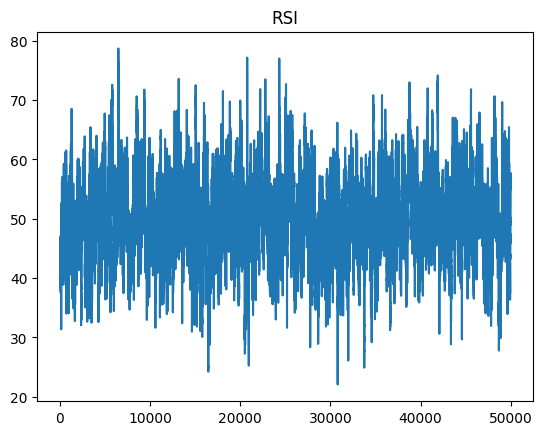

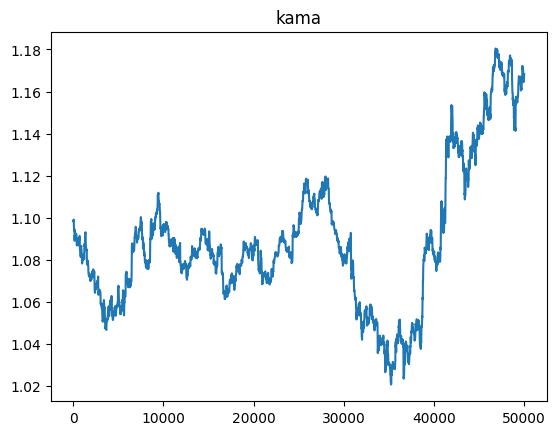

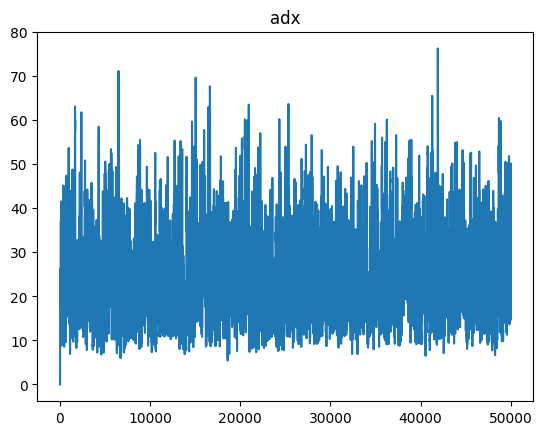

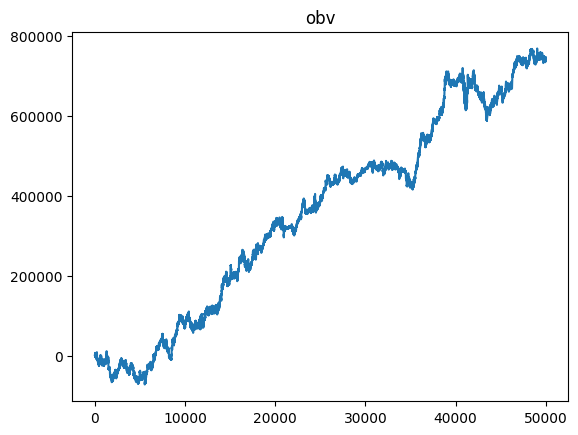

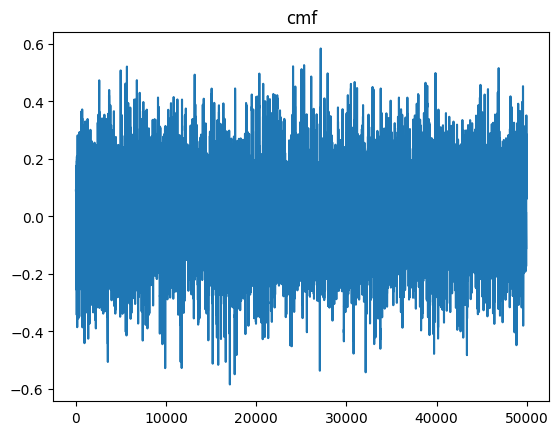

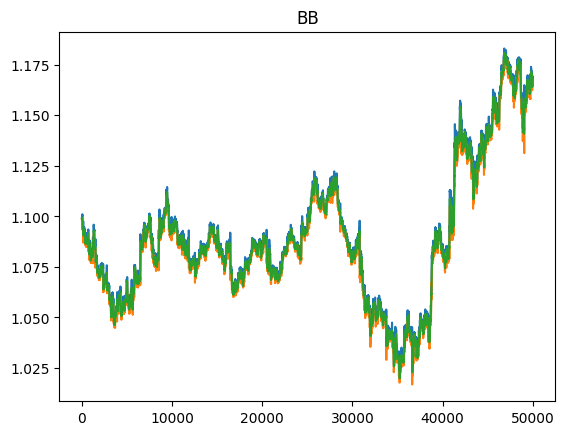

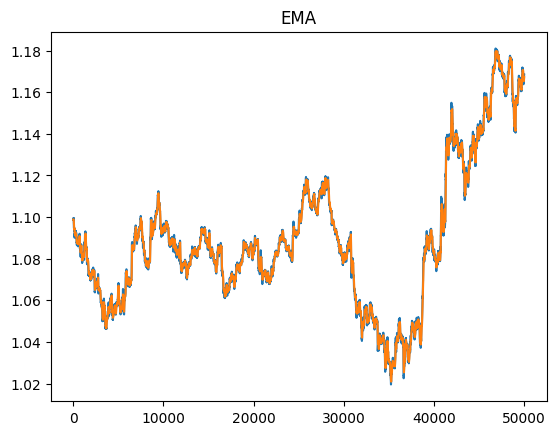

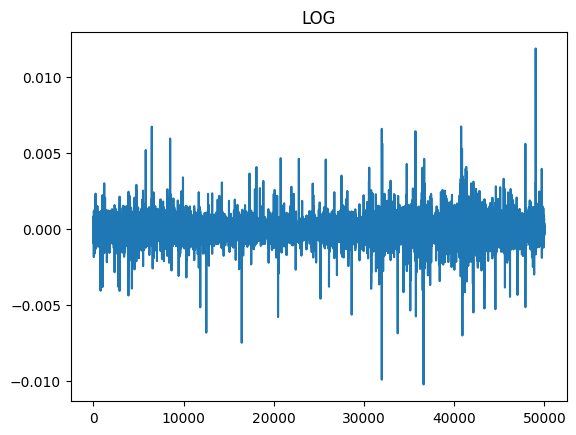

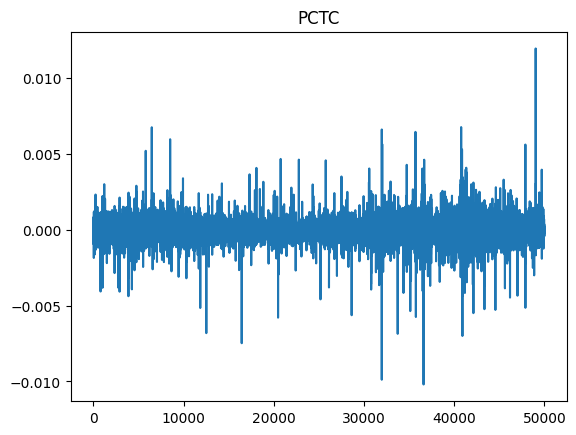

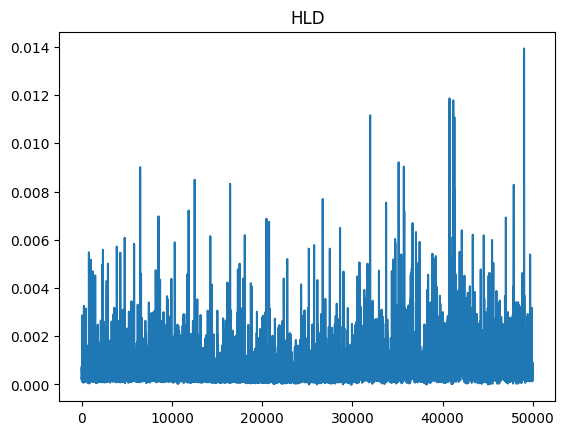

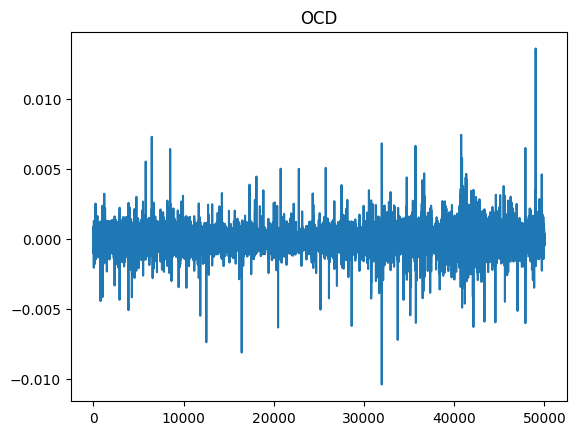

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.ao.nn.quantized.functional import conv2d

TARGET_COL = 3
LOOKBACK = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
HIDDEN_SIZE = 128
CONV1_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1
EPOCHS = 50

df = pd.read_csv("EURM15.csv")
target_value = df.iloc[len(df)-1:, TARGET_COL]

df = df.iloc[:len(df)-1, 2:]
print(target_value)
df['RSI'] = ta.momentum.RSIIndicator(df['close'],window=50,fillna=False).rsi()
df['kama'] = ta.momentum.kama(df['close'],window=14,fillna=False)
df['adx'] = ta.trend.ADXIndicator(df['high'],df['low'],df['close'],window=14,fillna=False).adx()
df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['close'], volume=df['tick_volume']).on_balance_volume()
df['cmf'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['high'],low=df['low'],close=df['close'],volume=df['tick_volume'],window=20).chaikin_money_flow()
boll = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['BB_High'] = boll.bollinger_hband()
df['BB_Low'] = boll.bollinger_lband()
df['BB_Mid'] = boll.bollinger_mavg()
df['EMA_10'] = ta.trend.EMAIndicator(close=df['close'], window=10).ema_indicator()
df['EMA_50'] = ta.trend.EMAIndicator(close=df['close'], window=50).ema_indicator()
df['LOG'] = np.log(df['close'] / df['close'].shift(1))
df['PCTC'] = df['close'].pct_change()
df['HLD'] = df['high'] - df['low']
df['OCD'] = df['close'] - df['open']

df = df.bfill()

print(df)
plt.plot(df['RSI'])
plt.title('RSI')
plt.show()
plt.plot(df['kama'])
plt.title('kama')
plt.show()
plt.plot(df['adx'])
plt.title('adx')
plt.show()
plt.plot(df['obv'])
plt.title('obv')
plt.show()
plt.plot(df['cmf'])
plt.title('cmf')
plt.show()
plt.plot(df['BB_High'])
plt.plot(df['BB_Low'])
plt.plot(df['BB_Mid'])
plt.title('BB')
plt.show()
plt.plot(df['EMA_10'])
plt.plot(df['EMA_50'])
plt.title('EMA')
plt.show()
plt.plot(df['LOG'])
plt.title('LOG')
plt.show()
plt.plot(df['PCTC'])
plt.title('PCTC')
plt.show()
plt.plot(df['HLD'])
plt.title('HLD')
plt.show()
plt.plot(df['OCD'])
plt.title('OCD')
plt.show()

features = df.columns.tolist()

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)




In [2]:
from torch.utils.data import Dataset, DataLoader

train_size = (len(scaled_df) * 0.8)


def create_dataset(data):
    X,y = [],[]
    for i in range(len(data) - LOOKBACK - 1):
        X.append(data[i:(i + LOOKBACK), :])  # Take all columns
        y.append(data[i + LOOKBACK, TARGET_COL])

    return np.array(X), np.array(y)

X,y = create_dataset(scaled_df)

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)  # shuffle=False for time series
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)  # shuffle=False for time series

X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

class StockDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)




In [3]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,conv_channels, output_size, num_layers, dropout = 0.2, kernel_size = 3):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Conv layer

        # LSTM (input_size should be conv_channels)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [batch, seq_len, features]




        # LSTM
        out, _ = self.lstm(x)

        out = self.fc(out[:, -1, :])

        return out

num_features = scaled_df.shape[1]
model = LSTM(input_size=num_features, hidden_size=HIDDEN_SIZE, conv_channels=CONV1_SIZE,output_size=OUTPUT_SIZE,num_layers=NUM_LAYERS).to(device)

In [ ]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(x_batch.float())
        loss = criterion(y_pred.flatten(), y_batch.float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.5f}")




Epoch 1/50, Loss: 0.01013
Epoch 2/50, Loss: 0.00110
Epoch 3/50, Loss: 0.00090
Epoch 4/50, Loss: 0.00079
Epoch 5/50, Loss: 0.00071
Epoch 6/50, Loss: 0.00065
Epoch 7/50, Loss: 0.00062
Epoch 8/50, Loss: 0.00059
Epoch 9/50, Loss: 0.00056


In [ ]:

model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch.float())
        predictions.extend(y_pred.flatten().cpu().numpy())
        actuals.extend(y_batch.flatten().cpu().numpy())
        loss = criterion(y_pred.flatten(), y_batch.float())
        running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    print(f"Loss: {avg_loss:.5f}")

In [ ]:
predictions = np.array(predictions)
actuals = np.array(actuals)

def inverse_close(scaled_close):
    dummy = np.zeros((scaled_close.shape[0], len(features)))
    dummy[:, 3] = scaled_close
    return scaler.inverse_transform(dummy)[:, 3]

actual_prices = inverse_close(actuals.flatten())
pred_prices_test = inverse_close(predictions.flatten())


# Plot predictions vs real values
plt.figure(figsize=(10,5))
plt.plot(pred_prices_test[-10:], label="Real")
plt.plot(actual_prices[-10:], label="Predicted")
plt.legend()
plt.title("Test Results: Real vs Predicted")
plt.show()



In [ ]:
last_seq = scaled_df[-LOOKBACK:]
input_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(device)

print(last_seq.shape)
model.eval()

with torch.no_grad():
    next_scaled = model(input_seq.float())
    next_scaled = next_scaled.item()

dummy = np.zeros((1, scaled_df.shape[1]))
dummy[0, TARGET_COL] = next_scaled  # put predicted scaled value in target column

# Inverse transform
next_real = scaler.inverse_transform(dummy)[0, TARGET_COL]
print("Last Close", df.iloc[-1, TARGET_COL])
print("Next predicted value:", next_real)
print("Next real value:", target_value)